![](Images/Sentiment_Analysis.png)

# Twitter Sentiment Analysis
Author: Volha Puzikava
***

## Disclaimer
The described analyses fulfill educational purposes only. The hypothetical business case and the results of sentiment analysis should not be perceived as real customers' attitudes and served as a push for remedial actions, as they have not been approved by any professional media organization.
***

## Overview
Sentiment analysis, also referred to as opinion mining, is an approach that identifies the emotional tone behind a body of text and categorizes pieces of writing as positive, negative or neutral. 

Sentiment analysis is a popular way for organizations to determine and classify opinions about a product, service, or idea. With the help of sentiment analysis companies get a better understanding of how customers feel about their brand, gain insights that help to improve their products and services, make business more responsive to customer feedback, react quickly to negative sentiment and turn it around, monitor brand’s reputation in real-time, and keep customers happy by always putting their feelings first.

This project tends to analyze Twitter sentiment about Apple and Google products in order to detect negative mentions and take remedial actions before they escalate. 
***

## Business Problem
Tweeter Home Enterteinment Group asked to analyze Twitter sentiment about Apple and Google products in order to help businesses monitor their brands and understand customers needs. The main purpose of the analysis was to build an NLP model that could rate the sentiment of a Tweet based on its content and detect angry customers or negative mentions, so the company could take remedial actions fast before the negativity escalates.
***

## Data Understanding
The data for the analysis was taken from CrowdFlower via data.world links. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neutral.

The data represented an imbalanced multiclass classification problem. Since the company wanted to concentrate on the negative Tweets in order to take remedial actions fast, both false positives and false negatives were of a cost in the analysis. In the case of a false positive, a positive Tweet would be identified as negative and the company would have to spend resources and time to analyze it. However, in the case of a false negative, the model would identify a negative Tweet as positive, and the company would miss the sentiment of interest and let negativity escalate. Since the class proportion in the analyzed dataset was skewed and both false negatives and false positives were balanced in importance, F-measure, or the harmonic mean of the precision and recall values, was chosen as an evaluation metric. However, because in this particular situation false negatives were more important to minimize, while false positives were still significant (for the company it would be better not to miss any negative tweets than spend time on analyzing positives that were identifies as negatives), F-measure with more attention on recall was preferred.

The solution for this problem was found by using the Fbeta-measure. The Fbeta-measure is an abstraction of the F-measure where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coefficient called beta: 
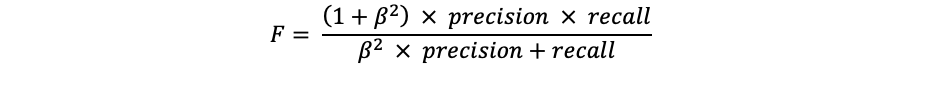

The β parameter is a strictly positive value that is used to describe the relative importance of recall to precision. A larger β value puts a higher emphasis on recall, while a smaller value puts a higher emphasis on precision. Three common values for the beta parameter are as follows:

* F0.5-Measure (beta=0.5): More weight on precision, less weight on recall.
* F1-Measure (beta=1.0): Balance the weight on precision and recall.
* F2-Measure (beta=2.0): Less weight on precision, more weight on recall

In our scenario, F2-measure of negative tweets was used as an evaluation metric.
***

## Data Preparation and Exploration
The data was uploaded and analyzed. Since the column containing product information the tweet was directed at, had about 64% of null values, it was excluded from the analysis. The columns with the text review and emotions were renamed to 'text' and 'category' respectively. The categories 'No emotion toward brand or product' and 'I can't tell' were treated as neutral emotions. The distribution of sentiments were plotted.

In [1]:
# Load the data
import pandas as pd

df = pd.read_csv('Data/tweet_product_company.csv', encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [2]:
# Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# Check the percentage of null values
def nulls_summary_table(df):
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count', 'null_percentage']
    return null_values

nulls_summary_table(df)

,null_count,null_percentage
tweet_text,1,0.000110
emotion_in_tweet_is_directed_at,5802,0.638073
is_there_an_emotion_directed_at_a_brand_or_product,0,0.000000


In [4]:
# Check the distribution of Tweets' sentiments
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
# Rename the columns' titles
data = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]
data = data.rename(columns = {'tweet_text' : 'text',\
                              'is_there_an_emotion_directed_at_a_brand_or_product' : 'category'})
# Remove null values
data.dropna(inplace=True)
data.head()

,text,category
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [6]:
# Remove apostrophes to rename the categories
data['category'] = data['category'].replace("[',]", "", regex=True)
data['category'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I cant tell                            156
Name: category, dtype: int64

In [7]:
# Rename categories 'No emotion toward brand or product' and 'I cant tell' to 'Neutral emotion'
data['category'].replace('No emotion toward brand or product', 'Neutral emotion', inplace=True)
data['category'].replace('I cant tell', 'Neutral emotion', inplace=True)
data['category'].value_counts()

Neutral emotion     5544
Positive emotion    2978
Negative emotion     570
Name: category, dtype: int64

In [8]:
# Check for class imbalance
print("Raw Counts:")
print(data['category'].value_counts())
print()
print('Percentages:')
print(data['category'].value_counts(normalize=True))

Raw Counts:
Neutral emotion     5544
Positive emotion    2978
Negative emotion     570
Name: category, dtype: int64

Percentages:
Neutral emotion     0.609767
Positive emotion    0.327541
Negative emotion    0.062692
Name: category, dtype: float64


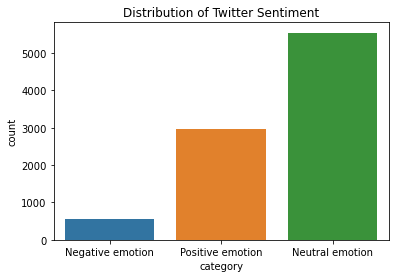

In [9]:
# Plot the distribution of values in column 'stroke'
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.countplot(data['category'])
plt.title('Distribution of Twitter Sentiment')
plt.savefig('distribution_sentiment');

According to the plot, the majority of the Tweets (around 61%) were rated as neutral. 33% of Tweets in the dataset belonged to positive class, while only 6% were rated as negative. Mapping was used to transform categories of sentiments into numerical values, and a new column 'label' was created.

In [10]:
# Transform categories into numerical variables using mapping
label = {
    'Neutral emotion' : 0,
    'Positive emotion' : 1,
    'Negative emotion' : 2
}
label_data = data['category'].map(label)

new_df = data.copy()
new_df['label'] = label_data
new_df.head()

,text,category,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,1


In [11]:
# Check the type of each column
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      9092 non-null   object
 1   category  9092 non-null   object
 2   label     9092 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 604.1+ KB


A train-test split was performed. The prediction target for the analysis was the column 'label', so the data was separated into a train set and test set accordingly. 

In [12]:
# Split the outcome and predictors
X = new_df[['text', 'category']]
y = new_df['label']

In [13]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    4185
1    2215
2     419
Name: label, dtype: int64 

 0    1359
1     763
2     151
Name: label, dtype: int64


In [14]:
# Save training set as a dataframe
X_train = pd.DataFrame(X_train, columns = ['text', 'category'])
X_train.head()

,text,category
8605,Perfect attention to detail RT @mention Google...,Negative emotion
1303,my iphone was stolen and I got it back !!!!!! ...,Neutral emotion
8759,fuck I love Austin. Just left the Youtube Goog...,Positive emotion
5021,Spotted something rare a few minutes ago...a p...,Neutral emotion
3210,@mention fyi RT @mention I'll be at the Austi...,Neutral emotion


The first step of data cleaning in training set was standardizing case. The typical way to standardize case was to make everything lowercase. After making the case consistent, hashtags and @mentions were removed from the text. The text was then converted from a single long string into a set of tokens by using RegexpTokenizer. Stopwords were removed as they didn't contain useful information. The final step in the cleaning process was lemmatizing, that used part-of-speech tagging to determine how to transform a word.

In [15]:
# Transform training data to lowercase
X_train['text'] = X_train['text'].str.lower()
X_train.head()

,text,category
8605,perfect attention to detail rt @mention google...,Negative emotion
1303,my iphone was stolen and i got it back !!!!!! ...,Neutral emotion
8759,fuck i love austin. just left the youtube goog...,Positive emotion
5021,spotted something rare a few minutes ago...a p...,Neutral emotion
3210,@mention fyi rt @mention i'll be at the austi...,Neutral emotion


In [16]:
# Remove hashtags and @mention
X_train['text'] = X_train['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
X_train['text'] = X_train['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
X_train.head()

,text,category
8605,perfect attention to detail rt google recreat...,Negative emotion
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion
8759,fuck i love austin. just left the youtube goog...,Positive emotion
5021,spotted something rare a few minutes ago...a p...,Neutral emotion
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion


In [17]:
# Tokenize the data; create new column with tokenized data
import nltk
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
X_train['tokenized'] = X_train['text'].apply(tokenizer.tokenize)
X_train.head()

,text,category,tokenized
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]"
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,..."


In [18]:
# Remove stopwords; create new column without stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

X_train['no_stopwords'] = X_train['tokenized'].apply(remove_stopwords)
X_train.head()

,text,category,tokenized,no_stopwords
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[perfect, attention, detail, rt, google, recre..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[iphone, stolen, got, back]"
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[fuck, love, austin, left, youtube, google, pa..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[spotted, something, rare, minutes, ago, phone..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[fyi, rt, austin, convention, center, today, f..."


In [19]:
# Download the collection of tags for classifying part-of-speech
import nltk
nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to /Users/olga/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [20]:
# Tag the words from the text; create new column with tags
from nltk import pos_tag

X_train['tagged'] = X_train.no_stopwords.apply(pos_tag)
X_train.head()

,text,category,tokenized,no_stopwords,tagged
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[perfect, attention, detail, rt, google, recre...","[(perfect, JJ), (attention, NN), (detail, NN),..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[iphone, stolen, got, back]","[(iphone, NN), (stolen, VBN), (got, VBD), (bac..."
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[fuck, love, austin, left, youtube, google, pa...","[(fuck, VBN), (love, NN), (austin, NN), (left,..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[spotted, something, rare, minutes, ago, phone...","[(spotted, VBN), (something, NN), (rare, JJ), ..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[fyi, rt, austin, convention, center, today, f...","[(fyi, NN), (rt, NN), (austin, JJ), (conventio..."


In [21]:
# Transform the tags into the tags of our lemmatizers
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def tagged(token_list):
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in token_list]
    return doc_tagged

X_train['tagged'] = X_train['tagged'].apply(tagged)
X_train.head()

,text,category,tokenized,no_stopwords,tagged
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[perfect, attention, detail, rt, google, recre...","[(perfect, a), (attention, n), (detail, n), (r..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[iphone, stolen, got, back]","[(iphone, n), (stolen, v), (got, v), (back, r)]"
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[fuck, love, austin, left, youtube, google, pa...","[(fuck, v), (love, n), (austin, n), (left, v),..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[spotted, something, rare, minutes, ago, phone...","[(spotted, v), (something, n), (rare, a), (min..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[fyi, rt, austin, convention, center, today, f...","[(fyi, n), (rt, n), (austin, a), (convention, ..."


In [22]:
# Lemmatize the text; create new column with lemmatized text
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(token[0], token[1]) for token in text]

X_train['lemmatized'] = X_train.tagged.apply(lemmatize_text)
X_train.head()

,text,category,tokenized,no_stopwords,tagged,lemmatized
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[perfect, attention, detail, rt, google, recre...","[(perfect, a), (attention, n), (detail, n), (r...","[perfect, attention, detail, rt, google, recre..."
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[iphone, stolen, got, back]","[(iphone, n), (stolen, v), (got, v), (back, r)]","[iphone, steal, get, back]"
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[fuck, love, austin, left, youtube, google, pa...","[(fuck, v), (love, n), (austin, n), (left, v),...","[fuck, love, austin, leave, youtube, google, p..."
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[spotted, something, rare, minutes, ago, phone...","[(spotted, v), (something, n), (rare, a), (min...","[spot, something, rare, minute, ago, phone, ma..."
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[fyi, rt, austin, convention, center, today, f...","[(fyi, n), (rt, n), (austin, a), (convention, ...","[fyi, rt, austin, convention, center, today, f..."


Once the data was cleaned up (case standardized and tokenized), some exploratory data analysis was performed. Frequency distribution of top 10 tokens for each category was visualized with the help of a tool from NLTK called FreqDist. It turned out that top 5 words were the same for neutral and positive sentiments. Better visualization of the words with the highest frequency within each category was achieved by using a word cloud, or tag cloud. 

To get the tokens out of the text, the TF-IDF algorithm ('Term Frequency-Inverse Document Frequency') was used. It didn't only count the term frequency within each document, but also included how rare the term was. Since the goal of the analysis was to distinguish the content of Tweets from others in corpus, TF-IDF was the most appropriate vectorizer.

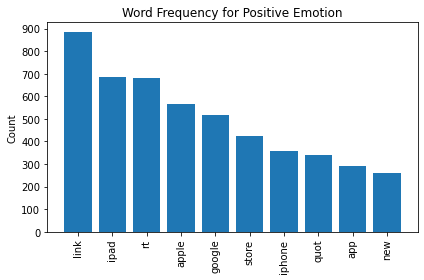

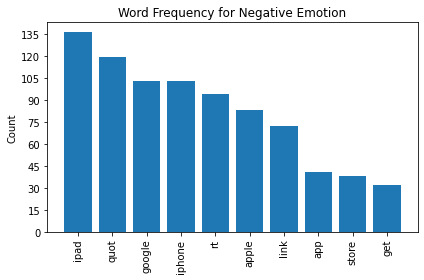

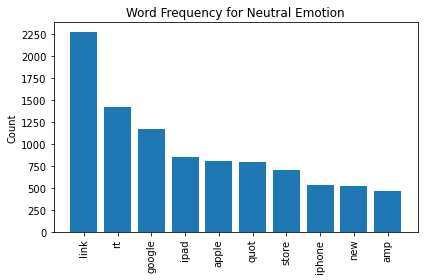

In [23]:
from nltk import FreqDist
from matplotlib.ticker import MaxNLocator

# Create a frequency distribution for each category in X_train
positive_freq = FreqDist(X_train[X_train['category']=='Positive emotion']['lemmatized'].explode())
negative_freq = FreqDist(X_train[X_train['category']=='Negative emotion']['lemmatized'].explode())
neutral_freq = FreqDist(X_train[X_train['category']=='Neutral emotion']['lemmatized'].explode())

def visualize_top_10(freq_dist, title):
    
    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
    # Set up plot and plot data
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    ax.bar(tokens, counts)
    
    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='x', rotation=90)
    
# Plot the top 10 tokens for each category
visualize_top_10(positive_freq, "Word Frequency for Positive Emotion")
visualize_top_10(negative_freq, "Word Frequency for Negative Emotion")
visualize_top_10(neutral_freq, "Word Frequency for Neutral Emotion")

In [24]:
# Transform lemmatized tokens into lemmatized text; create new column
def lemmatized(text):
    return " ".join(text)

X_train['lemmatized_text'] = X_train.lemmatized.apply(lemmatized)
X_train.head()

,text,category,tokenized,no_stopwords,tagged,lemmatized,lemmatized_text
8605,perfect attention to detail rt google recreat...,Negative emotion,"[perfect, attention, to, detail, rt, google, r...","[perfect, attention, detail, rt, google, recre...","[(perfect, a), (attention, n), (detail, n), (r...","[perfect, attention, detail, rt, google, recre...",perfect attention detail rt google recreate co...
1303,my iphone was stolen and i got it back !!!!!!,Neutral emotion,"[my, iphone, was, stolen, and, got, it, back]","[iphone, stolen, got, back]","[(iphone, n), (stolen, v), (got, v), (back, r)]","[iphone, steal, get, back]",iphone steal get back
8759,fuck i love austin. just left the youtube goog...,Positive emotion,"[fuck, love, austin, just, left, the, youtube,...","[fuck, love, austin, left, youtube, google, pa...","[(fuck, v), (love, n), (austin, n), (left, v),...","[fuck, love, austin, leave, youtube, google, p...",fuck love austin leave youtube google party ma...
5021,spotted something rare a few minutes ago...a p...,Neutral emotion,"[spotted, something, rare, few, minutes, ago, ...","[spotted, something, rare, minutes, ago, phone...","[(spotted, v), (something, n), (rare, a), (min...","[spot, something, rare, minute, ago, phone, ma...",spot something rare minute ago phone make appl...
3210,fyi rt i'll be at the austin convention cen...,Neutral emotion,"[fyi, rt, ll, be, at, the, austin, convention,...","[fyi, rt, austin, convention, center, today, f...","[(fyi, n), (rt, n), (austin, a), (convention, ...","[fyi, rt, austin, convention, center, today, f...",fyi rt austin convention center today fam show...


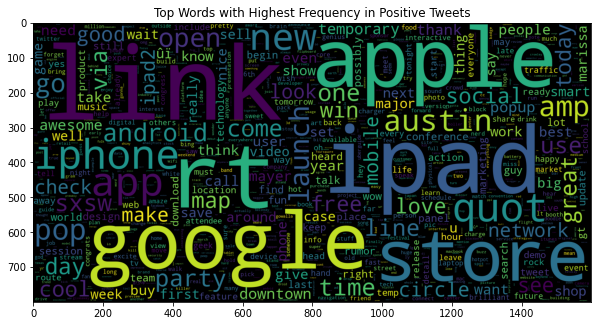

In [27]:
# Visualize the words with the highest frequency within positive category 
from wordcloud import WordCloud

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(
    " ".join(X_train[X_train['category']=='Positive emotion'].lemmatized_text))
plt.title('Top Words with Highest Frequency in Positive Tweets')
plt.imshow(wc)
plt.savefig('positive_sentiment');

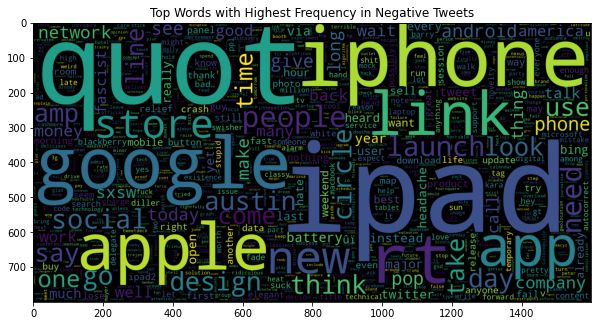

In [28]:
# Visualize the words with the highest frequency within negative category
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(
    " ".join(X_train[X_train['category']=='Negative emotion'].lemmatized_text))
plt.title('Top Words with Highest Frequency in Negative Tweets')
plt.imshow(wc)
plt.savefig('negative_sentiment');

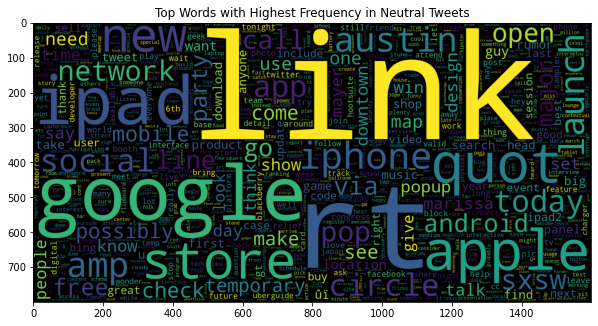

In [29]:
# Visualize the words with the highest frequency within neutral category
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(
    " ".join(X_train[X_train['category']=='Neutral emotion'].lemmatized_text))
plt.title('Top Words with Highest Frequency in Neutral Tweets')
plt.imshow(wc)
plt.savefig('neutral_sentiment');

In [36]:
# Import the vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer on X_train['lemmatized_text'] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['lemmatized_text'])
df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())
df.head()

,00,000,00am,00pm,02,03,0310apple,06,10,100,...,ûïspecial,ûïthe,ûïwin,ûò,ûòand,ûó,ûócan,ûólewis,ûólots,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since the data was imbalanced, SMOTE (the Synthetic Minority Oversampling Technique) was used in order to improve the models' performance on the minority class. The technique oversampled negative and positive categories to have the same number of examples as the category with neutral sentiments.

In [37]:
# Use SMOTE class to improve the model's performance on the minority class
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Preview the synthetic sample class distribution
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)
print(y_train_resampled.value_counts())

2    4185
1    4185
0    4185
Name: label, dtype: int64


Before building the models, the preprocessing steps as stated above were applied to the test data, so the models performances could be evaluated on unseen data.

In [38]:
# Save test set as a dataframe
X_test = pd.DataFrame(X_test, columns = ['text', 'category'])

# Transform testing data to lowercase; remove hashtags and @mentions
X_test['text'] = X_test['text'].str.lower()
X_test['text'] = X_test['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
X_test['text'] = X_test['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)

# Tokenize the data
basic_token_pattern_test = r"(?u)\b\w\w+\b"
tokenizer_test = RegexpTokenizer(basic_token_pattern_test)
X_test['tokenized'] = X_test['text'].apply(tokenizer_test.tokenize)

# Remove stopwords
X_test['no_stopwords'] = X_test['tokenized'].apply(remove_stopwords)
X_test['tagged'] = X_test.no_stopwords.apply(pos_tag)
X_test['tagged'] = X_test['tagged'].apply(tagged)

# Lemmatize text
X_test['lemmatized'] = X_test.tagged.apply(lemmatize_text)
X_test['lemmatized_text_test'] = X_test.lemmatized.apply(lemmatized)
X_test.head()

,text,category,tokenized,no_stopwords,tagged,lemmatized,lemmatized_text_test
7169,google close to launching new social network -...,Neutral emotion,"[google, close, to, launching, new, social, ne...","[google, close, launching, new, social, networ...","[(google, n), (close, r), (launching, v), (new...","[google, close, launch, new, social, network, ...",google close launch new social network circle ...
2089,iphone charging at {link},Neutral emotion,"[iphone, charging, at, link]","[iphone, charging, link]","[(iphone, n), (charging, v), (link, n)]","[iphone, charge, link]",iphone charge link
2303,"the walk by lady bird lake was lovely, but goo...",Negative emotion,"[the, walk, by, lady, bird, lake, was, lovely,...","[walk, lady, bird, lake, lovely, google, maps,...","[(walk, n), (lady, a), (bird, n), (lake, n), (...","[walk, lady, bird, lake, lovely, google, map, ...",walk lady bird lake lovely google map travel t...
928,ûï not a rumor: apple doing popup store in do...,Positive emotion,"[ûï, not, rumor, apple, doing, popup, store, i...","[ûï, rumor, apple, popup, store, downtown, aus...","[(ûï, a), (rumor, n), (apple, n), (popup, n), ...","[ûï, rumor, apple, popup, store, downtown, aus...",ûï rumor apple popup store downtown austin amp...
5895,rt google to launch major new social network ...,Neutral emotion,"[rt, google, to, launch, major, new, social, n...","[rt, google, launch, major, new, social, netwo...","[(rt, n), (google, n), (launch, n), (major, a)...","[rt, google, launch, major, new, social, netwo...",rt google launch major new social network call...


In [39]:
# Fit the vectorizer on X_test['lemmatized_text_test'] and transform it
X_test_vectorized = tfidf.transform(X_test['lemmatized_text_test'])
df_test = pd.DataFrame(X_test_vectorized.toarray(), columns=tfidf.get_feature_names())

***

## Data Modeling

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

mnb = MultinomialNB()
mnb.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(mnb.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(mnb.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.8424532058940661
Accuracy of Test Set:
0.5868895732512098


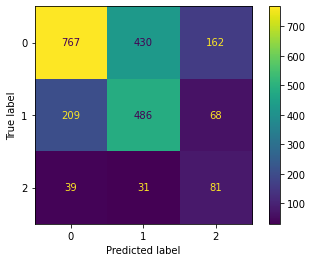

In [44]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mnb, X_test_vectorized, y_test);
# FP = 230

In [45]:
from sklearn.metrics import classification_report
mnb_preds = mnb.predict(X_test_vectorized)

print('Classification Report of Multinomial Naive Bayes Model:')
print(classification_report(y_test, mnb_preds))

Classification Report of Multinomial Naive Bayes Model:
              precision    recall  f1-score   support

           0       0.76      0.56      0.65      1359
           1       0.51      0.64      0.57       763
           2       0.26      0.54      0.35       151

    accuracy                           0.59      2273
   macro avg       0.51      0.58      0.52      2273
weighted avg       0.64      0.59      0.60      2273



 A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In [47]:
from sklearn.metrics import f1_score
mnb_f1_score = f1_score(y_test, mnb_preds, average=None)
mnb_f1_score = mnb_f1_score[2]
mnb_f1_score

0.3506493506493507

In [62]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test, mnb_preds, average=None, labels=[2], beta=2)

array([0.44262295])

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(logreg.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(logreg.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.8874551971326164
Accuracy of Test Set:
0.6449626044874615


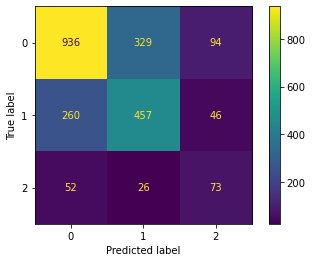

In [39]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, X_test_vectorized, y_test);
# FP = 140

In [40]:
logreg_preds = logreg.predict(X_test_vectorized)

print('Classification Report of Logistic Regression Model:')
print(classification_report(y_test, logreg_preds))

Classification Report of Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1359
           1       0.56      0.60      0.58       763
           2       0.34      0.48      0.40       151

    accuracy                           0.64      2273
   macro avg       0.55      0.59      0.57      2273
weighted avg       0.66      0.64      0.65      2273



In [41]:
logreg_precision_score = precision_score(y_test, logreg_preds, average=None)
logreg_precision_score = logreg_precision_score[2]
logreg_precision_score 

0.3427230046948357

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

logreg_tuned = LogisticRegression(random_state=42)
param_grid = {'penalty' : ['l2', 'none'],
              'C' : range(0,1),
              'max_iter' : [50, 100, 150]}
    
grid_search = GridSearchCV(estimator = logreg_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'C': range(0, 1), 'max_iter': [50, 100, 150],
                         'penalty': ['l2', 'none']},
             scoring='accuracy')

In [43]:
grid_search.best_params_

{'C': 0, 'max_iter': 100, 'penalty': 'none'}

In [44]:
logreg_tuned = LogisticRegression(random_state=42,
                                  multi_class='multinomial',
                                  solver='lbfgs',
                                  C=0,
                                  max_iter=100,
                                  penalty='none')
logreg_tuned.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(logreg_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(logreg_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9573874950219037
Accuracy of Test Set:
0.63308402991641


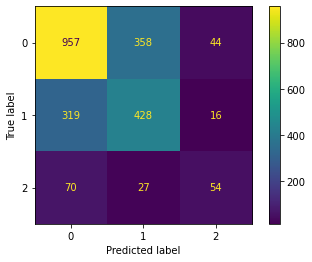

In [45]:
plot_confusion_matrix(logreg_tuned, X_test_vectorized, y_test);

In [46]:
logreg_tuned_preds = logreg_tuned.predict(X_test_vectorized)

print('Classification Report of Logistic Regression Tuned Model:')
print(classification_report(y_test, logreg_tuned_preds))

Classification Report of Logistic Regression Tuned Model:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1359
           1       0.53      0.56      0.54       763
           2       0.47      0.36      0.41       151

    accuracy                           0.63      2273
   macro avg       0.57      0.54      0.55      2273
weighted avg       0.63      0.63      0.63      2273



In [47]:
logreg_tuned_precision_score = precision_score(y_test, logreg_tuned_preds, average=None)
logreg_tuned_precision_score = logreg_tuned_precision_score[2]
logreg_tuned_precision_score

0.47368421052631576

In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(knn.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(knn.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9070489844683393
Accuracy of Test Set:
0.5631324241091069


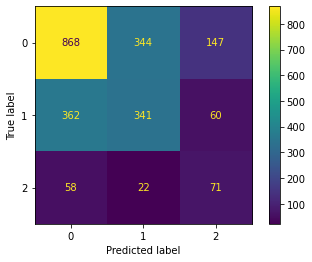

In [49]:
plot_confusion_matrix(knn, X_test_vectorized, y_test);
# FP = 207

In [50]:
knn_preds = knn.predict(X_test_vectorized)

print('Classification Report of KNN Model:')
print(classification_report(y_test, knn_preds))

Classification Report of KNN Model:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1359
           1       0.48      0.45      0.46       763
           2       0.26      0.47      0.33       151

    accuracy                           0.56      2273
   macro avg       0.47      0.52      0.48      2273
weighted avg       0.58      0.56      0.57      2273



In [51]:
knn_precision_score = precision_score(y_test, knn_preds, average=None)
knn_precision_score = knn_precision_score[2]
knn_precision_score

0.25539568345323743

In [52]:
knn_tuned = KNeighborsClassifier()
param_grid = {'n_neighbors' : [5, 10, 15, 20],
              'weights' : ['uniform', 'distance'],
              'metric' : ['manhattan', 'euclidean', 'minkowski']}
    
grid_search = GridSearchCV(estimator = knn_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean', 'minkowski'],
                         'n_neighbors': [5, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [53]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [54]:
knn_tuned = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
knn_tuned.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(knn_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(knn_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9939466348068499
Accuracy of Test Set:
0.6264848218213814


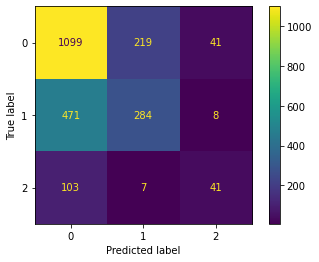

In [55]:
plot_confusion_matrix(knn_tuned, X_test_vectorized, y_test);

In [56]:
knn_tuned_preds = knn_tuned.predict(X_test_vectorized)

print('Classification Report of KNN Tuned Model:')
print(classification_report(y_test, knn_tuned_preds))

Classification Report of KNN Tuned Model:
              precision    recall  f1-score   support

           0       0.66      0.81      0.72      1359
           1       0.56      0.37      0.45       763
           2       0.46      0.27      0.34       151

    accuracy                           0.63      2273
   macro avg       0.56      0.48      0.50      2273
weighted avg       0.61      0.63      0.61      2273



In [57]:
knn_tuned_precision_score = precision_score(y_test, knn_tuned_preds, average=None)
knn_tuned_precision_score = knn_tuned_precision_score[2]
knn_tuned_precision_score

0.45555555555555555

In [58]:
from sklearn.svm import SVC

svc = SVC(random_state=42, probability=True, decision_function_shape='ovo')
svc.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(svc.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(svc.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9598566308243728
Accuracy of Test Set:
0.6827980642322922


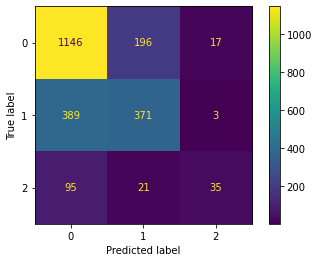

In [59]:
plot_confusion_matrix(svc, X_test_vectorized, y_test);

In [60]:
svc_preds = svc.predict(X_test_vectorized)

print('Classification Report of SVC Model:')
print(classification_report(y_test, svc_preds))

Classification Report of SVC Model:
              precision    recall  f1-score   support

           0       0.70      0.84      0.77      1359
           1       0.63      0.49      0.55       763
           2       0.64      0.23      0.34       151

    accuracy                           0.68      2273
   macro avg       0.66      0.52      0.55      2273
weighted avg       0.67      0.68      0.67      2273



In [61]:
svc_precision_score = precision_score(y_test, svc_preds, average=None)
svc_precision_score = svc_precision_score[2]
svc_precision_score

0.6363636363636364

In [62]:
svc_tuned = SVC(random_state=42, probability=True, decision_function_shape='ovo')
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 3, 'scale']}
    
grid_search = GridSearchCV(estimator = svc_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=SVC(decision_function_shape='ovo', probability=True,
                           random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 3, 'scale']},
             scoring='accuracy')

In [63]:
grid_search.best_params_

{'C': 10, 'gamma': 3}

In [64]:
svc_tuned = SVC(random_state=42, probability=True, decision_function_shape='ovo', C=10, gamma=3)
svc_tuned.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(svc_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(svc_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.987495021903624
Accuracy of Test Set:
0.6471623405191377


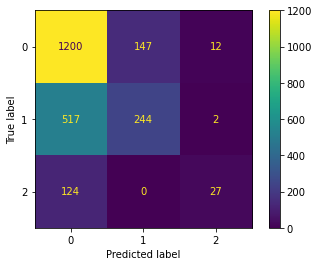

In [65]:
plot_confusion_matrix(svc_tuned, X_test_vectorized, y_test);

In [66]:
svc_tuned_preds = svc_tuned.predict(X_test_vectorized)

print('Classification Report of SVC Model:')
print(classification_report(y_test, svc_tuned_preds))

Classification Report of SVC Model:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      1359
           1       0.62      0.32      0.42       763
           2       0.66      0.18      0.28       151

    accuracy                           0.65      2273
   macro avg       0.64      0.46      0.48      2273
weighted avg       0.64      0.65      0.61      2273



In [67]:
svc_tuned_precision_score = precision_score(y_test, svc_tuned_preds, average=None)
svc_tuned_precision_score = svc_tuned_precision_score[2]
svc_tuned_precision_score

0.6585365853658537

In [68]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(forest.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(forest.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9941059338908801
Accuracy of Test Set:
0.6709194896612406


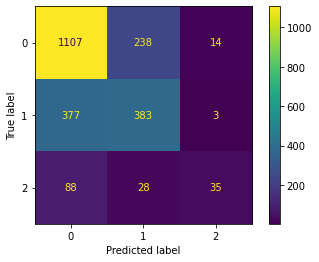

In [69]:
plot_confusion_matrix(forest, X_test_vectorized, y_test);

In [70]:
forest_preds = forest.predict(X_test_vectorized)

print('Classification Report of Random Forest Model:')
print(classification_report(y_test, forest_preds))

Classification Report of Random Forest Model:
              precision    recall  f1-score   support

           0       0.70      0.81      0.76      1359
           1       0.59      0.50      0.54       763
           2       0.67      0.23      0.34       151

    accuracy                           0.67      2273
   macro avg       0.66      0.52      0.55      2273
weighted avg       0.66      0.67      0.66      2273



In [71]:
forest_precision_score = precision_score(y_test, forest_preds, average=None)
forest_precision_score = forest_precision_score[2]
forest_precision_score

0.6730769230769231

In [72]:
forest_tuned = RandomForestClassifier(random_state = 42)
param_grid = {'n_estimators': [75, 100, 125, 150],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features' : ['sqrt', 'log2', 'none']}
    
grid_search = GridSearchCV(estimator = forest_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', 'none'],
                         'n_estimators': [75, 100, 125, 150]},
             scoring='accuracy')

In [73]:
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 150}

In [74]:
forest_tuned = RandomForestClassifier(random_state=42, n_estimators=150, criterion='entropy', max_features='log2')
forest_tuned.fit(X_train_resampled, y_train_resampled)
print("Accuracy of Train Set:")
print(forest_tuned.score(X_train_resampled, y_train_resampled))
print("Accuracy of Test Set:")
print(forest_tuned.score(X_test_vectorized, y_test))

Accuracy of Train Set:
0.9941059338908801
Accuracy of Test Set:
0.6775186977562693


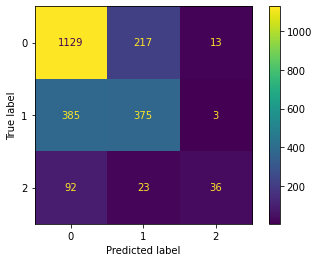

In [75]:
plot_confusion_matrix(forest_tuned, X_test_vectorized, y_test);

In [76]:
forest_tuned_preds = forest_tuned.predict(X_test_vectorized)

print('Classification Report of Random Forest Model:')
print(classification_report(y_test, forest_tuned_preds))

Classification Report of Random Forest Model:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1359
           1       0.61      0.49      0.54       763
           2       0.69      0.24      0.35       151

    accuracy                           0.68      2273
   macro avg       0.67      0.52      0.55      2273
weighted avg       0.67      0.68      0.66      2273



In [77]:
forest_tuned_precision_score = precision_score(y_test, forest_tuned_preds, average=None)
forest_tuned_precision_score = forest_tuned_precision_score[2]
forest_tuned_precision_score

0.6923076923076923

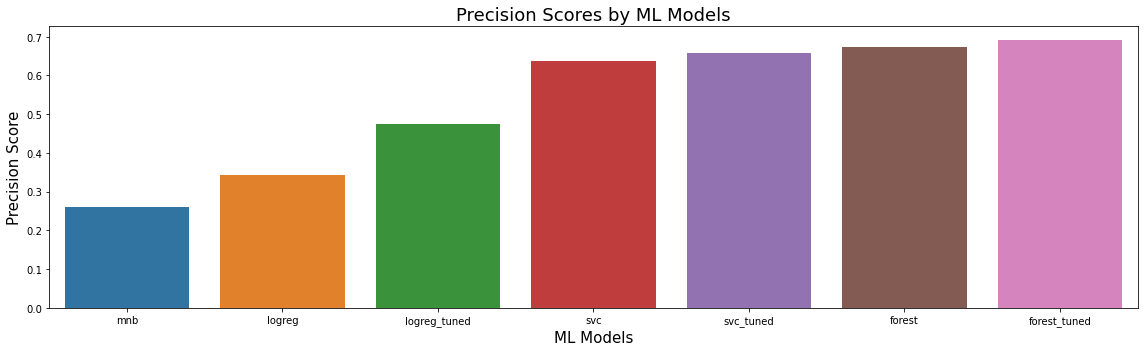

In [79]:
# Plot the graph with the best recall scores for different models
prec_mnb = mnb_precision_score
prec_logreg = logreg_precision_score
prec_logreg_tuned = logreg_tuned_precision_score
prec_svc = svc_precision_score
prec_svc_tuned = svc_tuned_precision_score
prec_forest = forest_precision_score
prec_forest_tuned = forest_tuned_precision_score

precision = [prec_mnb, prec_logreg, prec_logreg_tuned, prec_svc, prec_svc_tuned,
            prec_forest, prec_forest_tuned]
models = ['mnb', 'logreg', 'logreg_tuned', 'svc', 'svc_tuned',
          'forest', 'forest_tuned']
precision_score = [round(num, 3) for num in precision]

df_precision = pd.DataFrame({'models': models, 'precision': precision_score}).sort_values(
    'precision', ascending=True)
plt.figure(figsize=(16,5))
sns.barplot(x='models', y='precision', data=df_precision)
plt.xlabel("ML Models", size=15)
plt.ylabel("Precision Score", size=15)
plt.title("Precision Scores by ML Models", size=18)
plt.tight_layout()
plt.savefig("precision.png", dpi=100)
